In [1]:
# Read packedges

import pandas as pd
import pandas.testing as tm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm

from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa


from scipy.fft import fft, ifft, fftfreq

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

import itertools
from itertools import combinations, chain

from scipy.stats import pearsonr

import re

import functions

import early_warning_detection_functions

from datetime import datetime

import pymannkendall as mk

import math

import trend_timeseries

from scipy.stats import friedmanchisquare

from sklearn.metrics import r2_score

from pmdarima.preprocessing import FourierFeaturizer
from pmdarima.datasets import load_wineind
from sklearn.linear_model import LinearRegression


# Read processed data

In [22]:
df = pd.read_parquet('//home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_imed.parquet')



In [23]:
df.year_week.min()

'2022-47'

In [24]:
df = df.assign(phc_4_lag_0 = df.atend_ivas_4,
               otc_4_lag_0 = df.num_otc_ivas_4)

# Run regressions

## Early warning on OTC series with APS

### Cities without trend and sezonality

In [25]:
df.columns

Index(['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 'dtrend_ivas_negbi',
       'dtrend_otc_negbi', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'phc_4_lag_1', 'phc_4_lag_2',
       'phc_4_lag_3', 'otc_4_lag_1', 'otc_4_lag_2', 'otc_4_lag_3',
       'phc_4_lag_0', 'otc_4_lag_0'],
      dtype='object')

In [26]:
# select cities without trend and sezonality in PHC

df1 = df[(df.p_value_otc_negbi_friedman >= 0.05) & (df.p_values_negbi_num_otc_ivas_4 >= 0.05)]

print('number of imediate without trend and sezonality', df1.co_imed.nunique(), 'percentage', round(df1.co_imed.nunique()*100/510,1) )

number of imediate without trend and sezonality 187 percentage 36.7


In [27]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [28]:
formulas

['num_otc_ivas_4 ~ otc_4_lag_1 + phc_4_lag_0',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0',
 'num_otc_ivas_4 ~ otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1',
 'num_otc_ivas_4 ~ otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2',
 'num_otc_ivas_4 ~ otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3',
 'num_otc_ivas_4 ~ otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3']

In [29]:
## Keep the best model formulas and AIC

lst = []

for code in df1.co_imed.unique():

    #print(code)

    data = df1[df1.co_imed == code]

    # Placeholder for the best model
    best_model = None
    best_aic = float('inf')
    best_formula = None

    # Loop through all formulas to find the best model based on AIC
    for formula in formulas:
        
        # Fit the model
        alpha = 1
        model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
        
        # Check the AIC of the current model
        current_aic = model.aic
        
        # Update the best model if the current model has a lower AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_formula = formula

    data = data.assign(best_formula = best_formula)
    data = data.assign(best_aic = best_aic)
    
    lst.append(data)

lst_dfs_cities1 = lst



#### save predicted values, upperbound and warning columns

# we know the best model that adjust to the data of each municipality. Thus:

lst = []

for data in lst_dfs_cities1:
    # Fit the model
    alpha = 1
    model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()

    # Extract fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid_deviance
    
    sigma = np.std(residuals)
    sigma_ = np.std(fitted_values)
    sigma_t = fitted_values.rolling(window=5).std()
    
    data = data.assign(fitted_values_otc_only = fitted_values,
                      residuals_otc_only = residuals,
                      sigma_otc_only = sigma,
                      sigma__otc_only = sigma_,
                      sigma_t_otc_only = sigma_t)
    
    lst.append(data)
    
lst_dfs_cities1 = lst


lst = []
for i in range(len(lst_dfs_cities1)):
    
    data = lst_dfs_cities1[i]
    
    # Calculate control limits for the original series
    w = 1 #data.w_best.iloc[0]
    
    data = data.assign(UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only,
                      LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only)

    data = data.assign(out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= data.UCL_otc_only).astype(int),
                       out_of_limits_below_otc_only = (data['num_otc_ivas_4'] < data.LCL_otc_only).astype(int)
                       )
    
    lst.append(data)
    
lst_dfs_cities1 = lst   

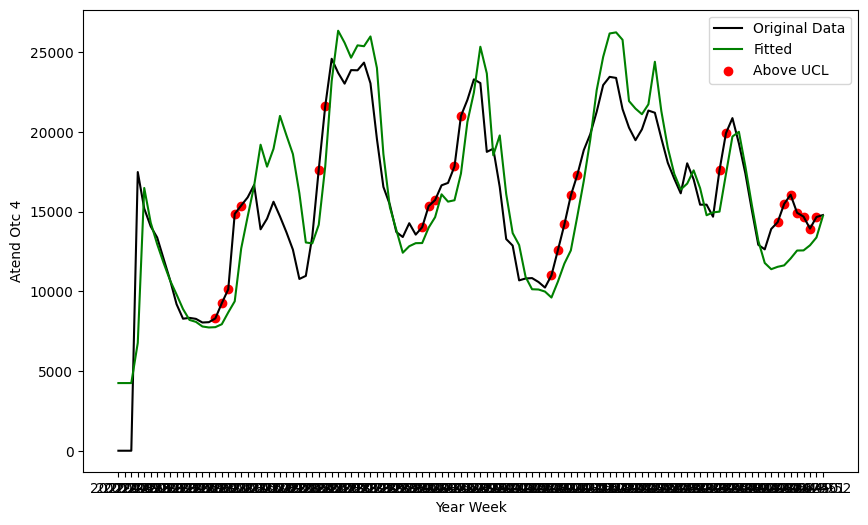

In [35]:
dta = lst_dfs_cities1[0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['fitted_values_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


### Cities with trend and without sezonality

In [36]:
# select cities without trend and sezonality in PHC

df2 = df[(df.p_value_otc_negbi_friedman >= 0.05) & (df.p_values_negbi_num_otc_ivas_4 < 0.05)]

print('number of imediate with trend and without sezonality', df2.co_imed.nunique(), 'percentage', round(df2.co_imed.nunique()*100/510,1) )

number of imediate with trend and without sezonality 66 percentage 12.9


In [39]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = 'time_trend + ' + ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [40]:
## Keep the best model formulas and AIC
lst = []

for code in df2.co_imed.unique():
    print(f"Processing {code}...")

    data = df2[df2.co_imed == code].copy()
    data = data.assign(time_trend=np.arange(len(data)))

    # Initialize placeholders
    best_model = None
    best_aic = float('inf')
    best_formula = np.nan  # Set default as NaN

    # Try fitting models
    for formula in formulas:
        try:
            model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
            current_aic = model.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_formula = formula

        except Exception as e:
            print(f"Skipping formula {formula} for {code}: {e}")
            continue  # Skip to the next formula

    # Assign best formula and AIC (or NaN if model failed)
    data = data.assign(best_formula=best_formula, best_aic=best_aic if best_aic != float('inf') else np.nan)
    lst.append(data)

lst_dfs_cities2 = lst  # Store results

#### Save predicted values, upper bound, and warning columns

lst = []

for data in lst_dfs_cities2:
    
    if pd.isna(data.best_formula.iloc[0]):
        # If no valid model, create NaN columns
        data = data.assign(
                fitted_values_otc_only=np.nan,
                residuals_otc_only=np.nan,
                sigma_otc_only=np.nan,
                sigma__otc_only=np.nan,
                sigma_t_otc_only=np.nan
            )
    else:
        # Fit the model and calculate residuals
        model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid_deviance

        # Calculate sigmas
        sigma = np.std(residuals)
        sigma_ = np.std(fitted_values)
        sigma_t = fitted_values.rolling(window=5).std()

        # Assign values
        data = data.assign(
                fitted_values_otc_only=fitted_values,
                residuals_otc_only=residuals,
                sigma_otc_only=sigma,
                sigma__otc_only=sigma_,
                sigma_t_otc_only=sigma_t
            )

    lst.append(data)

lst_dfs_cities2 = lst  # Store results

### Control limits and out-of-limits detection

lst = []

for data in lst_dfs_cities2:
    
    if data['fitted_values_otc_only'].isna().all():
        # If no valid fitted values, assign NaNs
        data = data.assign(
                    UCL_otc_only=np.nan,
                    LCL_otc_only=np.nan,
                    out_of_limits_above_otc_only=np.nan,
                    out_of_limits_below_otc_only=np.nan
            )
    else:
        w = 1  # Default weight
        
        UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only
        LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only
        
        data = data.assign(
                UCL_otc_only =  UCL_otc_only,
                LCL_otc_only =  LCL_otc_only,
                out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= UCL_otc_only).astype(int),
                out_of_limits_below_otc_only=(data['num_otc_ivas_4'] < LCL_otc_only).astype(int)
            )

    lst.append(data)

lst_dfs_cities2 = lst  # Store final results


Processing 120002...
Processing 120003...
Processing 120004...
Processing 120005...
Processing 270002...
Processing 270005...
Processing 130003...
Processing 130006...
Processing 160002...
Processing 290003...
Processing 290012...
Processing 290018...
Processing 230018...
Processing 520008...
Processing 520022...
Processing 210006...
Processing 210008...
Processing 210011...
Processing 210021...
Processing 310035...
Processing 310045...
Processing 310047...
Processing 310057...
Processing 310058...
Processing 310063...
Processing 310064...
Processing 310066...
Processing 510004...
Processing 510006...
Processing 510008...
Processing 510013...
Processing 150002...
Processing 150003...
Processing 150011...
Processing 150013...
Processing 150019...
Processing 260008...
Processing 220006...
Processing 220017...
Processing 410005...
Processing 410013...
Processing 330003...
Processing 330013...
Processing 240002...
Processing 240003...
Processing 240004...
Processing 240005...
Processing 24

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 350029...
Processing 170009...
Processing 170010...


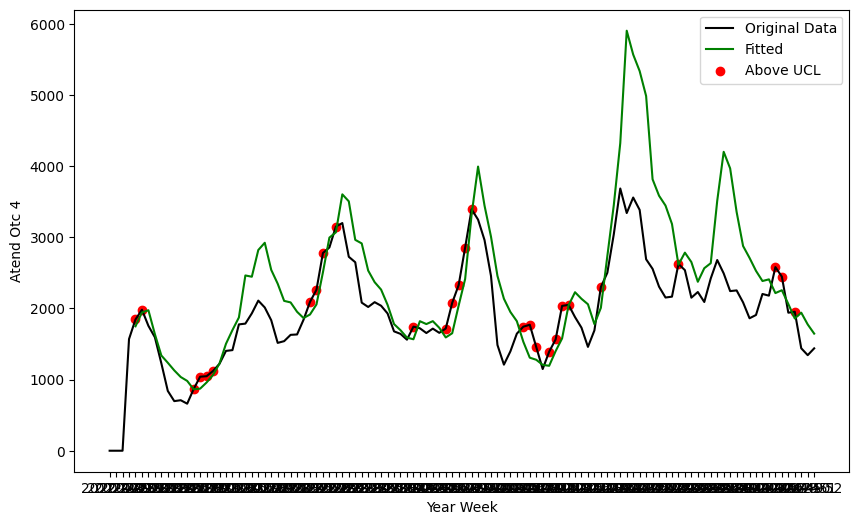

In [41]:
dta = lst_dfs_cities2[0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['UCL_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


### Cities without trend and with sezonality

In [51]:
# select cities without trend and sezonality in PHC

df3 = df[(df.p_value_otc_negbi_friedman < 0.05) & (df.p_values_negbi_num_otc_ivas_4 >= 0.05)]

print('number of imed without trend and with sezonality', df3.co_imed.nunique(), 'percentage', round(df3.co_imed.nunique()*100/510,1) )

number of imed without trend and with sezonality 224 percentage 43.9


In [52]:
lst_dfs_cities3 = []

for code in df3.co_imed.unique():
    
    set_muni = df3[df3.co_imed == code]

    lst_dfs_cities3.append(set_muni)

lst_dfs_cities3 = early_warning_detection_functions.harmonic(lst_dfs_cities3, 'num_otc_ivas_4')

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [53]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = 'Reconstructed + ' + ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [55]:
## Keep the best model formulas and AIC
lst = []

for data in lst_dfs_cities3:
    print(f"Processing {data.co_imed.iloc[0]}...")

    #data = df3[df3.co_ibge == code].copy()
    #data = data.assign(time_trend=np.arange(len(data)))

    # Initialize placeholders
    best_model = None
    best_aic = float('inf')
    best_formula = np.nan  # Set default as NaN

    # Try fitting models
    for formula in formulas:
        try:
            model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
            current_aic = model.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_formula = formula

        except Exception as e:
            print(f"Skipping formula {formula} for {code}: {e}")
            continue  # Skip to the next formula

    # Assign best formula and AIC (or NaN if model failed)
    data = data.assign(best_formula=best_formula, best_aic=best_aic if best_aic != float('inf') else np.nan)
    lst.append(data)

lst_dfs_cities3 = lst  # Store results


#### Save predicted values, upper bound, and warning columns

lst = []

for data in lst_dfs_cities3:
    
    if pd.isna(data.best_formula.iloc[0]):
        # If no valid model, create NaN columns
        data = data.assign(
                fitted_values_otc_only=np.nan,
                residuals_otc_only=np.nan,
                sigma_otc_only=np.nan,
                sigma__otc_only=np.nan,
                sigma_t_otc_only=np.nan
            )
    else:
        # Fit the model and calculate residuals
        model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid_deviance

        # Calculate sigmas
        sigma = np.std(residuals)
        sigma_ = np.std(fitted_values)
        sigma_t = fitted_values.rolling(window=5).std()

        # Assign values
        data = data.assign(
                fitted_values_otc_only=fitted_values,
                residuals_otc_only=residuals,
                sigma_otc_only=sigma,
                sigma__otc_only=sigma_,
                sigma_t_otc_only=sigma_t
            )

    lst.append(data)

lst_dfs_cities3 = lst  # Store results

### Control limits and out-of-limits detection

lst = []

for data in lst_dfs_cities3:
    
    if data['fitted_values_otc_only'].isna().all():
        # If no valid fitted values, assign NaNs
        data = data.assign(
                    UCL_otc_only=np.nan,
                    LCL_otc_only=np.nan,
                    out_of_limits_above_otc_only=np.nan,
                    out_of_limits_below_otc_only=np.nan
            )
    else:
        w = 1  # Default weight
        
        UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only
        LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only
        
        data = data.assign(
                UCL_otc_only =  UCL_otc_only,
                LCL_otc_only =  LCL_otc_only,
                out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= UCL_otc_only).astype(int),
                out_of_limits_below_otc_only=(data['num_otc_ivas_4'] < LCL_otc_only).astype(int)
            )

    lst.append(data)

lst_dfs_cities3 = lst  # Store final results


Processing 270007...
Processing 270009...
Processing 290002...
Processing 290008...
Processing 290011...
Processing 290016...
Processing 290017...
Processing 290020...
Processing 290023...
Processing 290024...
Processing 290025...
Processing 290026...
Processing 290027...
Processing 290028...
Processing 290029...
Processing 290030...
Processing 290031...
Processing 290032...
Processing 290033...
Processing 290034...
Processing 230014...
Processing 320002...
Processing 320004...
Processing 320005...
Processing 320008...
Processing 520001...
Processing 520003...
Processing 520006...
Processing 520007...
Processing 520009...
Processing 520012...
Processing 520015...
Processing 520017...
Processing 520019...
Processing 520020...
Processing 210007...
Processing 210013...
Processing 210015...
Processing 310001...
Processing 310002...
Processing 310005...
Processing 310006...
Processing 310007...
Processing 310008...
Processing 310009...
Processing 310011...
Processing 310012...
Processing 31

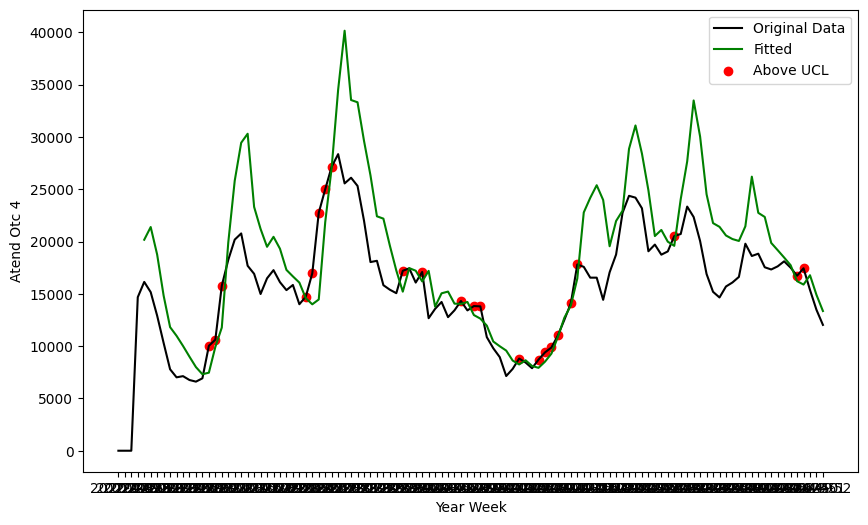

In [56]:
dta = lst_dfs_cities3[4]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['UCL_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


### Cities with trend and with sezonality

In [57]:
# select cities without trend and sezonality in PHC

df4 = df[(df.p_value_otc_negbi_friedman < 0.05) & (df.p_values_negbi_num_otc_ivas_4 < 0.05)]

print('number of imed with trend and sezonality', df4.co_imed.nunique(), 'percentage', round(df4.co_imed.nunique()*100/510,1) )

number of imed with trend and sezonality 33 percentage 6.5


In [58]:
lst_dfs_cities4 = []

for code in df4.co_imed.unique():
    
    set_muni = df4[df4.co_imed == code]

    lst_dfs_cities4.append(set_muni)

lst_dfs_cities4 = early_warning_detection_functions.harmonic(lst_dfs_cities4, 'num_otc_ivas_4')

In [59]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = 'time_trend + Reconstructed + ' + ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [61]:
## Keep the best model formulas and AIC
lst = []

for data in lst_dfs_cities4:
    print(f"Processing {data.co_imed.iloc[0]}...")

    #data = df3[df3.co_ibge == code].copy()
    data = data.assign(time_trend=np.arange(len(data)))

    # Initialize placeholders
    best_model = None
    best_aic = float('inf')
    best_formula = np.nan  # Set default as NaN

    # Try fitting models
    for formula in formulas:
        try:
            model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
            current_aic = model.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_formula = formula

        except Exception as e:
            print(f"Skipping formula {formula} for {code}: {e}")
            continue  # Skip to the next formula

    # Assign best formula and AIC (or NaN if model failed)
    data = data.assign(best_formula=best_formula, best_aic=best_aic if best_aic != float('inf') else np.nan)
    lst.append(data)

lst_dfs_cities4 = lst  # Store results


Processing 270011...
Processing 130008...
Processing 290014...
Processing 310003...
Processing 310004...
Processing 310010...
Processing 310031...
Processing 310033...
Processing 310036...
Processing 310038...
Processing 310043...
Processing 310061...
Processing 250008...
Processing 410003...
Processing 410009...
Processing 410029...
Processing 430005...
Processing 430010...
Processing 430012...
Processing 430014...
Processing 430015...
Processing 430022...
Processing 430025...
Processing 430028...
Processing 430031...
Processing 420005...
Processing 420007...
Processing 420010...
Processing 420015...
Processing 420016...
Processing 420018...
Processing 280004...
Processing 350010...


In [62]:
#### Save predicted values, upper bound, and warning columns

lst = []

for data in lst_dfs_cities4:
    
    if pd.isna(data.best_formula.iloc[0]):
        # If no valid model, create NaN columns
        data = data.assign(
                fitted_values_otc_only=np.nan,
                residuals_otc_only=np.nan,
                sigma_otc_only=np.nan,
                sigma__otc_only=np.nan,
                sigma_t_otc_only=np.nan
            )
    else:
        # Fit the model and calculate residuals
        model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid_deviance

        # Calculate sigmas
        sigma = np.std(residuals)
        sigma_ = np.std(fitted_values)
        sigma_t = fitted_values.rolling(window=5).std()

        # Assign values
        data = data.assign(
                fitted_values_otc_only=fitted_values,
                residuals_otc_only=residuals,
                sigma_otc_only=sigma,
                sigma__otc_only=sigma_,
                sigma_t_otc_only=sigma_t
            )

    lst.append(data)

lst_dfs_cities4 = lst  # Store results


In [63]:
### Control limits and out-of-limits detection

lst = []

for data in lst_dfs_cities4:
    
    if data['fitted_values_otc_only'].isna().all():
        # If no valid fitted values, assign NaNs
        data = data.assign(
                    UCL_otc_only=np.nan,
                    LCL_otc_only=np.nan,
                    out_of_limits_above_otc_only=np.nan,
                    out_of_limits_below_otc_only=np.nan
            )
    else:
        w = 1  # Default weight
        
        UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only
        LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only
        
        data = data.assign(
                UCL_otc_only =  UCL_otc_only,
                LCL_otc_only =  LCL_otc_only,
                out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= UCL_otc_only).astype(int),
                out_of_limits_below_otc_only=(data['num_otc_ivas_4'] < LCL_otc_only).astype(int)
            )

    lst.append(data)

lst_dfs_cities4 = lst  # Store final results


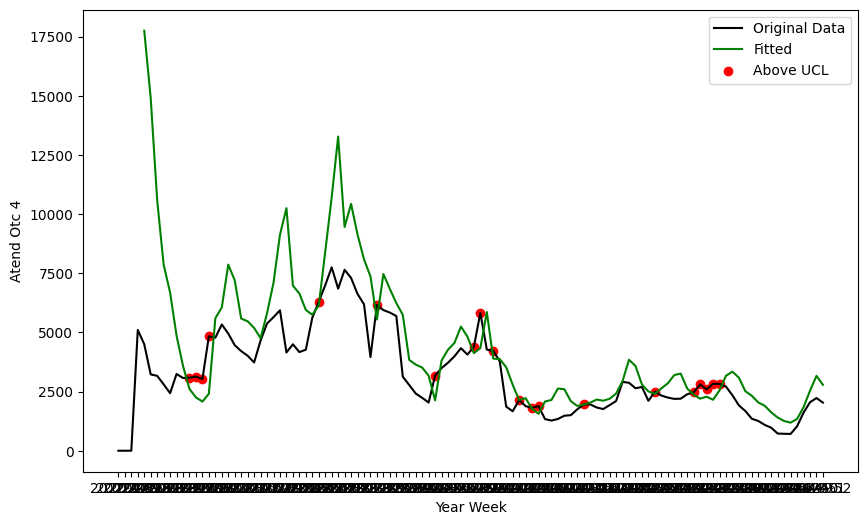

In [64]:
dta = lst_dfs_cities4[4]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['UCL_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


# Process and save data

In [65]:
len(lst_dfs_cities1) + len(lst_dfs_cities2) + len(lst_dfs_cities3) + len(lst_dfs_cities4)

510

In [66]:
lst_dfs_cities1[0].columns

Index(['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 'dtrend_ivas_negbi',
       'dtrend_otc_negbi', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'phc_4_lag_1', 'phc_4_lag_2',
       'phc_4_lag_3', 'otc_4_lag_1', 'otc_4_lag_2', 'otc_4_lag_3',
       'phc_4_lag_0', 'otc_4_lag_0', 'best_formula', 'best_aic',
       'fitted_values_otc_only', 'residuals_otc_only', 'sigma_otc_only',
       'sigma__otc_only', 'sigma_t_otc_only', 'UCL_otc_only', 'LCL_otc_only',
       'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only'],
      dtype='object')

In [67]:
lst1 = []

for data in lst_dfs_cities1:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)


for data in lst_dfs_cities2:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)

for data in lst_dfs_cities3:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)

for data in lst_dfs_cities4:

    data = data[['nm_uf', 'co_imed', 'Nome_imed',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)

In [68]:
final = pd.concat(lst1)

In [73]:
final = final.rename(columns = { 'fitted_values_otc_only': 'fitted_values_otc_with_aps', 
                                 'residuals_otc_only': 'residuals_otc_with_aps',
                                 'UCL_otc_only': 'UCL_otc_with_aps',
                                 'LCL_otc_only': 'LCL_otc_with_aps', 
                                 'out_of_limits_above_otc_only': 'out_of_limits_above_otc_with_aps',
                                 'out_of_limits_below_otc_only': 'out_of_limits_below_otc_with_aps'})

In [75]:
final.columns

Index(['nm_uf', 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts',
       'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas', 'num_otc_ivas',
       'atend_ivas_4', 'num_otc_ivas_4', 'best_formula', 'best_aic',
       'fitted_values_otc_with_aps', 'residuals_otc_with_aps',
       'UCL_otc_with_aps', 'LCL_otc_with_aps',
       'out_of_limits_above_otc_with_aps', 'out_of_limits_below_otc_with_aps'],
      dtype='object')

In [76]:
final.to_parquet('/home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_with_aps_imed.parquet')

